## Extraction des caractéristiques de forme

### Detection des points saillants

Les points saillants, c'est-à-dire les coins, sont des caractéristiques qui peuvent servir à décrire des formes. La méthode «Harris Corner Detection» dans OpenCV a été testée sur plusieurs images. Le code ci-dessous démontre l'application de cette méthode sur une image. Nous constatons que nous ne détectons que certains des points auxquels nous nous intéressons. D'un autre côté, d'autres points qui ne sont pas des coins ont aussi été détectés. Nous avons essayé de modifier des paramètres des fonctions `cv2.cornerHarris` et `cv2.threshold`, mais nous n'avons pas obtenu de résultats satisfaisants non plus. 

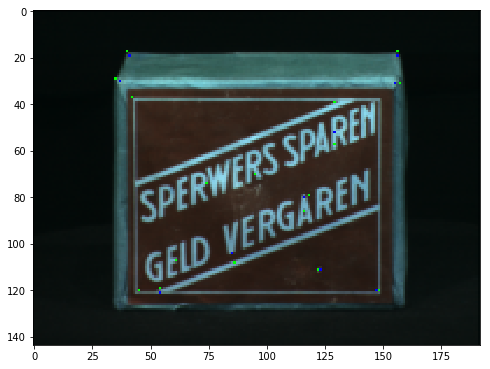

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

filename = 'datasets/aloi_red4_stereo/525/525_c.png'
img = cv2.imread(filename) # gives array
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# find Harris corners
gray = np.float32(gray)
dst = cv2.cornerHarris(gray,2,3,0.04)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.01*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)

# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(gray,np.float32(centroids),(5,5),(-1,-1),criteria)

# Now draw them
res = np.hstack((centroids,corners))
res = np.int0(res)
img[res[:,1],res[:,0]]=[0,0,255]
img[res[:,3],res[:,2]] = [0,255,0]

# Res contains the centroids in the following format: 
# [col_red, row_red], [col_green, row_green]
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.show()

### Detection des bords

En plus des coins, les bords peuvent aussi être utilisés pour l'extraction des caractéristiques de forme. Quant à la détection des bords, nous avons utilisé la fonction `cv2.findContours` pour trouver le bord extérieur de l'image. Pour améliorer l'efficacité de cette méthode, l'image a d'abord été convertie en noir et blanc. Nous avons ensuite appliqué une dilation et érosion à l'image avant d'utiliser la fonction `findContours`. Le code ci-dessous génère un résultat typique de cette méthode de détection de bords. Nous voyons que la méthode est capable de tracer le bord extérieur en général mais il se peut que la méthode ne marche pas très bien en certains cas. Cependant, nous allons encore utiliser les bords pour générer des caractéristques de forme. 

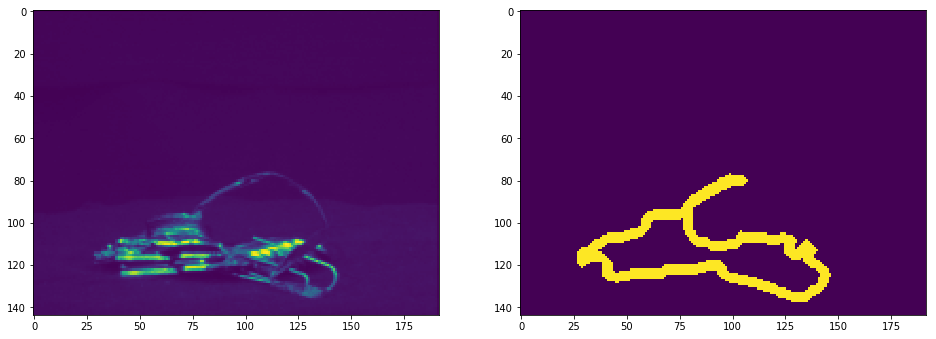

In [13]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

def outerContours(img):
    img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    ret, imbw = cv.threshold(img,30,255,cv.THRESH_BINARY)
    
    # dilation and erosion
    kernel = np.ones((5,5),np.uint8)
    imbw = cv.dilate(imbw,kernel,iterations = 1)
    imbw = cv.erode(imbw,kernel,iterations = 1)
    
    # Run findContours - Note the RETR_EXTERNAL flag
    # Also, we want to find the best contour possible with CHAIN_APPROX_NONE
    contours, hierarchy = cv.findContours(imbw.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
    
    # Prendre le contour le plus long si plusieurs sont identifiés
    if len(contours) > 1:
        s = 0
        for i in range(len(contours)):
            if contours[i].shape[0] > s:
                s = contours[i].shape[0]
                max_ele = i
        contours = [contours[max_ele]] 
    return contours

filename = 'datasets/aloi_red4_stereo/531/531_c.png'
img = cv.imread(filename)

# find contours
contours = outerContours(img)

# pre-treatment
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Create an output of all zeroes that has the same shape as the input
# image
out = np.zeros_like(img)

# On this output, draw all of the contours that we have detected
# in white, and set the thickness to be 3 pixels
cv.drawContours(out, contours, -1, 255, 3)

# Spawn new windows that shows us the donut
# (in grayscale) and the detected contour
fig, ax = plt.subplots(1,2,figsize=(16,8))
ax[0].imshow(img) 
ax[1].imshow(out)

### Génération des caractéristiques

Une fois que nous avons tracé le bord extérieur, nous pouvons en obtenir des caractéristiques. Les paramètres que nous allons calculer sont résumés ci-dessous. 
<br>
#### Ratio de circularité
Le rapport de la surface de la forme à la surface d'un cercle avec le même périmètre. Soient $C$ le ratio de circularité, $p$ le périmètre de la forme, et $A_s$ la surface de la forme. Ces variables sont liées par l'équation ci-dessous.
$$C = \frac{4\pi A_s}{p^2}$$
<br>
#### Modèle linéaire
Nous calculons la pente et l'ordonée à l'origine de la droite de régression,c'est-à-dire $A$ et $B$ dans l'équation
$$y=Ax+B$$
ce qui minimisent la somme des distances carrées de la droite au bord. 
<br>
#### Eccentricité
$$e = \sqrt{1-\frac{b^2}{a^2}}$$
où $e$ est l'éccentricité de la forme, et $b$ et $a$ sont la largeur et la longeur du plus petit rectangle qui contient la forme, avec toujours $b<a$. 
<br>
#### Energie moyenne de torsion (Average Bending Energy)
$$\text{BE} = \frac{1}{N}\sum^{N-1}_{s=0}K(s)^2$$
$$K(s) = \phi(s) - \phi(s-1)$$
$$\phi(s) = [\theta(s) - \theta(s-1)] \text{mod}(2\pi)$$